## import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import plot_confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_curve, plot_roc_curve

from sklearn.inspection import permutation_importance, plot_partial_dependence

## import data

In [3]:
df = pd.read_csv('data_processed.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175493 entries, 0 to 175492
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       175493 non-null  int64  
 1   backers_count            175493 non-null  int64  
 2   category                 175493 non-null  object 
 3   country                  175493 non-null  object 
 4   created_at               175493 non-null  object 
 5   deadline                 175493 non-null  object 
 6   is_starrable             175493 non-null  bool   
 7   launched_at              175493 non-null  object 
 8   name                     175493 non-null  object 
 9   staff_pick               175493 non-null  bool   
 10  state                    175493 non-null  object 
 11  usd_pledged              175493 non-null  float64
 12  sub_category             168321 non-null  object 
 13  creation_to_launch_days  175493 non-null  int64  
 14  camp

In [5]:
# Dropping row where clean_text is NaN
df.dropna(subset=['clean_text'], inplace=True)

In [6]:
df[df['clean_text'].isnull()]['id'].tolist()

[]

In [7]:
df.columns

Index(['id', 'backers_count', 'category', 'country', 'created_at', 'deadline',
       'is_starrable', 'launched_at', 'name', 'staff_pick', 'state',
       'usd_pledged', 'sub_category', 'creation_to_launch_days',
       'campaign_days', 'launch_day', 'deadline_day', 'clean_text',
       'pledge_per_backer', 'usd_goal'],
      dtype='object')

In [8]:
df.shape

(175492, 20)

## Preparing target and features

In [9]:
# Dropping columns and creating new dataframe
df_baseline = df.drop(['id', 'name', 'backers_count', 'created_at', 
                       'deadline', 'launched_at', 'sub_category',
                       'usd_pledged', 'pledge_per_backer'], axis=1)

In [10]:
df_baseline['state'] = df_baseline['state'].replace({'failed': 0, 'successful': 1})

In [11]:
# Creating dummy variables
df_baseline = pd.get_dummies(df_baseline, columns=[
    'category', 'country', 'staff_pick', 'launch_day',
    'deadline_day'], dummy_na=True)

In [12]:
y = df_baseline['state']

In [13]:
X = df_baseline.drop('state', axis=1)

In [14]:
X.shape

(175492, 65)

### NLP vectorization

In [15]:
corpus = df_baseline['clean_text'].values.tolist()

In [16]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.001)
X_tfidf = vectorizer.fit_transform(corpus)

In [17]:
X = X.drop(columns=['clean_text'])

In [18]:
#convert to dataframe for concatenation
X_tfidf = pd.DataFrame(X_tfidf.toarray())

In [19]:
#assign nlp features as column names using vectorizer
X_tfidf.columns = vectorizer.get_feature_names()

In [20]:
#reset dataframe indices to prepare for concatenation
X_tfidf.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)

In [21]:
X_all_feat = pd.concat([X, X_tfidf], axis = 1)

## Baseline Models

In [22]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(
    X_all_feat, y, test_size=0.25, random_state=42)

In [23]:
# Splitting Dataset into train and test set 
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(
    X_tfidf, y, test_size=0.25, random_state=42)

In [24]:
scaler = StandardScaler()
X_unscaled = pd.DataFrame(scaler.fit_transform(
    X_all_feat), columns=list(X_all_feat.columns))

In [25]:
# Splitting Dataset into train and test set for logreg
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_unscaled, y, test_size=0.25, random_state=42)

### logistic regression

In [26]:
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(X_train_s,y_train_s)

/home/main/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [27]:
# Making predictions
y_hat_train = logreg.predict(X_train_s)
y_hat_logreg = logreg.predict(X_test_s)

In [28]:
# Logistic regression scores
print("Logistic regression score for test set:", round(logreg.score(X_test_s, y_test_s),5))
print("\nClassification report:")
print(classification_report(y_test_s, y_hat_logreg))

Logistic regression score for test set: 0.74809

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68     17984
           1       0.77      0.81      0.79     25889

    accuracy                           0.75     43873
   macro avg       0.74      0.73      0.74     43873
weighted avg       0.75      0.75      0.75     43873



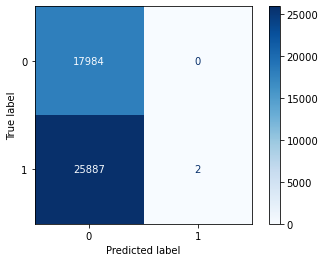

In [29]:
# Confusion matrix
plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues);

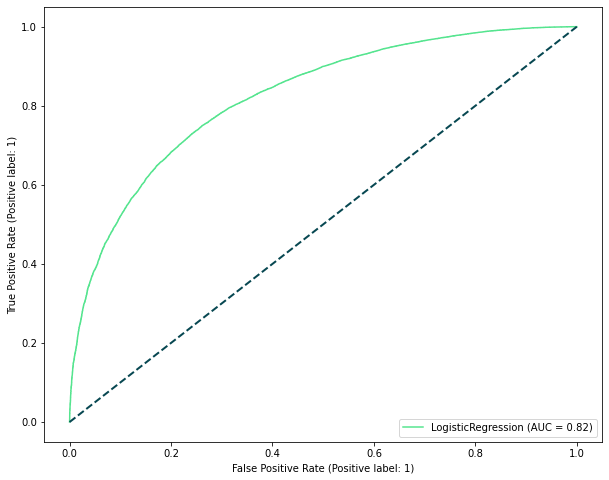

In [30]:
fig,ax=plt.subplots(figsize=(10,8))
lr_roc = plot_roc_curve(logreg, X_test_s, y_test_s, ax=ax, 
                        alpha=0.8, color='#2bde73')
ax.plot([0, 1], [0, 1], color='#074751', lw=2, linestyle='--');

### random forest

In [31]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=500, random_state=1,n_jobs=-1)

rf.fit(X_train, y_train)
                                     
# Test Prediction
y_hat_rf = rf.predict(X_test)

# Printing evaluation metric (accuracy-score) 
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(f1_score(y_test, y_hat_rf, average = 'weighted')))

Accuracy score: 0.775
f1 score: 0.7721439506165424


In [32]:
print("Random Forest Classifier score for test set:", round(rf.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_hat_rf))

Random Forest Classifier score for test set: 0.77474

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71     17984
           1       0.79      0.85      0.82     25889

    accuracy                           0.77     43873
   macro avg       0.77      0.76      0.76     43873
weighted avg       0.77      0.77      0.77     43873



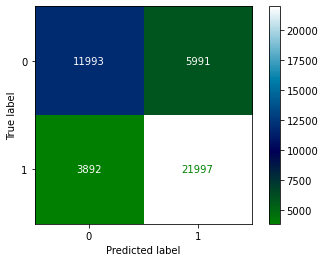

In [33]:
# Confusion matrix
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.ocean);

In [35]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
optm_idx = np.argmax(tpr_rf - fpr_rf)
optm_threshold = thresholds_rf[optm_idx]
print(f'The optimal threshold is {optm_threshold}')

The optimal threshold is 0.552


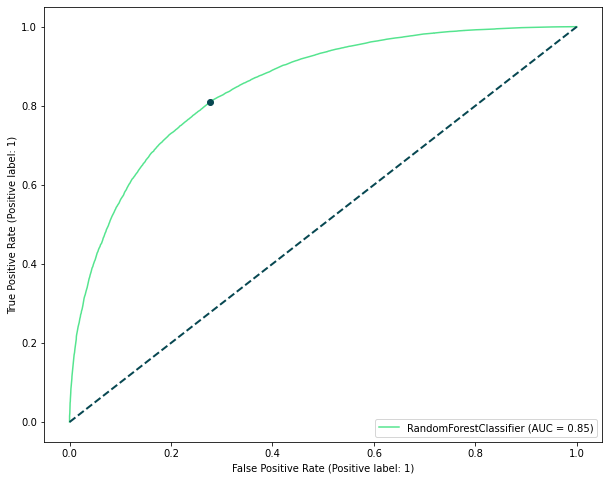

In [36]:
fig,ax=plt.subplots(figsize=(10,8))
rf_roc = plot_roc_curve(rf, X_test, y_test, ax=ax, 
                        alpha=0.8, color='#2bde73')
ax.plot(fpr_rf[293], tpr_rf[293], 'o', color='#074751', label='point')
ax.plot([0, 1], [0, 1], color='#074751', lw=2, linestyle='--');

In [37]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:40], y=fi_df['feature_names'][:40],
               palette="ch:s=.25,rot=-.25")
    #Add chart labels
    plt.title(model_type + '', fontsize=20)
    plt.xlabel('Feature Importance', fontsize=13)
    plt.ylabel('Feature Names', fontsize=13)

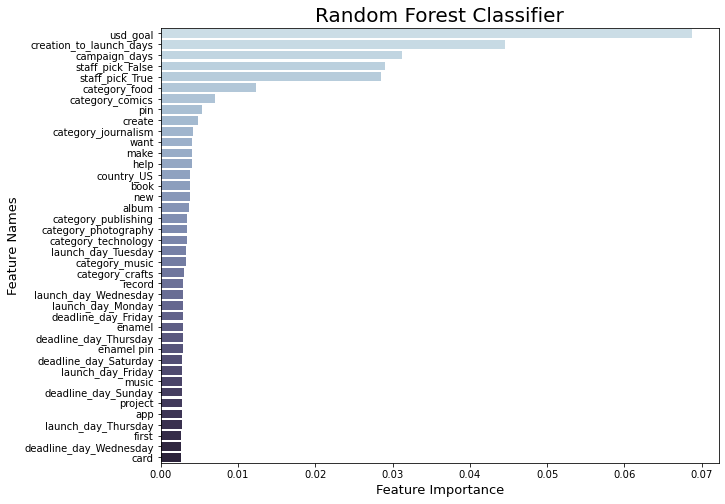

In [38]:
plot_feature_importance(rf.feature_importances_, X_all_feat.columns, 
                        'Random Forest Classifier')

### gradient boosting 

In [39]:
# Train and fit model                                                   
gb = GradientBoostingClassifier(random_state=1)

gb.fit(X_train, y_train)
                                     
# Test Prediction
y_hat_gb = gb.predict(X_test)

# Printing evaluation metric (accuracy-score) 
print('Accuracy score: {:.3}'.format(gb.score(X_test, y_test)))

# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(f1_score(y_test, y_hat_gb, average = 'weighted')))

Accuracy score: 0.751
f1 score: 0.7455356141952065


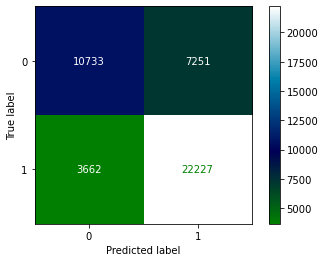

In [40]:
# Confusion matrix
plot_confusion_matrix(gb, X_test, y_test, cmap=plt.cm.ocean);

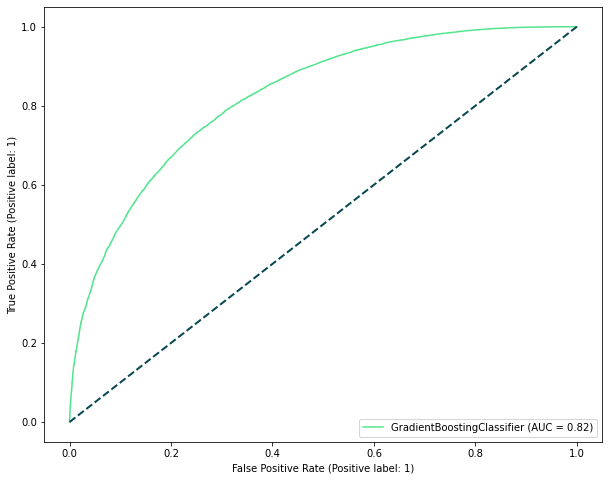

In [41]:
fig,ax=plt.subplots(figsize=(10,8))
gb_roc = plot_roc_curve(gb, X_test, y_test, ax=ax, 
                        alpha=0.8, color='#2bde73')
ax.plot([0, 1], [0, 1], color='#074751', lw=2, linestyle='--');